# General analysis of Real Data from the PDHD Detector

Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector.

As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. 

In [5]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [6]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES_df = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #trigger primitives for real data
TP_BRANCHES = ["event", "TP_channel", "TP_startT", "TP_peakT", "TP_peakADC", "TP_SADC", "TP_TOT", "TP_plane", "TP_TPC",
               "TP_trueX", "TP_trueY", 'TP_trueZ', 'TP_signal'] #trigger primites for MC data

#MC-specific branches
MC_BRANCHES = ["event", "Eng", "Px", "Py", "Pz", "P"] #MC information from the particle

#--simulation data containing 100 single muon events in the ProtoDUNE Horizontal Drift Geometry (PDHD)
mc  = load_data("../data/muons_simtps_pdhd_n100.root", MC_BRANCHES, 1000) #MC carlo output 
tps  = load_data("../data/muons_simtps_pdhd_n100.root", TP_BRANCHES, 1000)  #corresponding trigger primitive (TP) information  

In [7]:
#Let's load the data from runs
df_32973= load_data("../data/pdhd_run032973_tps.root", TP_BRANCHES_df, 1000)
df_32974= load_data("../data/pdhd_run032974_tps.root", TP_BRANCHES_df, 1000)
df_32975= load_data("../data/pdhd_run032975_tps.root", TP_BRANCHES_df, 1000)

df_32973.run_name = "Cosmic run 32973"
df_32974.run_name = "Cosmic run 32974"
df_32975.run_name = "Cosmic run 32975"

# Concatenate all three datasets
df_all = pd.concat([df_32973, df_32974, df_32975], ignore_index=True)

In [8]:
df_32974.head()

event    run  subrun  TP_channel         TP_startT  \
entry subentry                                                       
0     0             8  32974       1         191  3385479352352172   
      1             8  32974       1         191  3385479352352486   
      2             8  32974       1         191  3385479352355251   
      3             8  32974       1         191  3385479352356623   
      4             8  32974       1         193  3385479352352172   

                        TP_peakT  TP_TOT  TP_SADC  TP_peakADC  TP_plane  \
entry subentry                                                            
0     0         3385479352352176       7     1082         199         0   
      1         3385479352352488       6     1866         560         0   
      2         3385479352355256       9     1094         179         0   
      3         3385479352356626       7      962         191         0   
      4         3385479352352176       7      632         116         0   

                TP_TPC  
entry subentry          
0     0              0  
      1              0  
      2              0  
      3              0  
      4              0

In [9]:
#Let's see what event IDs exist in the file
triggers = df_32974.event.unique()
print(f"Event {triggers}")

Event [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288
 296 304 360 368]


In [10]:
# Global variable for APA ranges
apa_ranges = {
    "APA1": (0, 2560),
    "APA3": (2560, 5120),
    "APA2": (5120, 7680),
    "APA4": (7680, 10240),
}

### Examine general distributions from cosmic signals from the full PDHD detector (single run). 

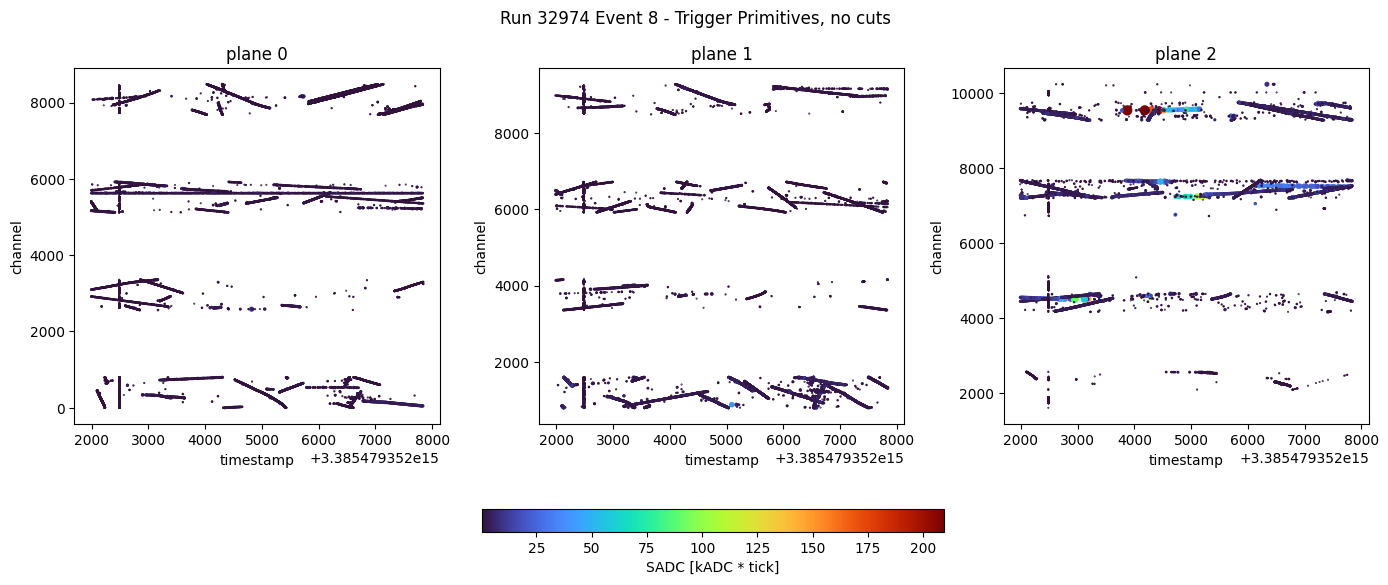

In [11]:
event = triggers[0] #single event
#timestamps correspond to microseconds, the big number is the first detection hit in timestamp

tps_32974 = df_32974[(df_32974.event == event) & (df_32974.TP_TOT > 1)]
vmin, vmax = tps_32974["TP_SADC"].min()/1e3, (tps_32974["TP_SADC"].max()/1e3)/2
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

for plane in range(3):
    tps = tps_32974[tps_32974.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")   

fig.suptitle(f"Run {df_32974['run'].unique()[0]} Event {event} - Trigger Primitives, no cuts")
fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

Minimum value 0.132, maximum 209.2665, mean 2.3198971898283123, std deviation 5.5452637809506


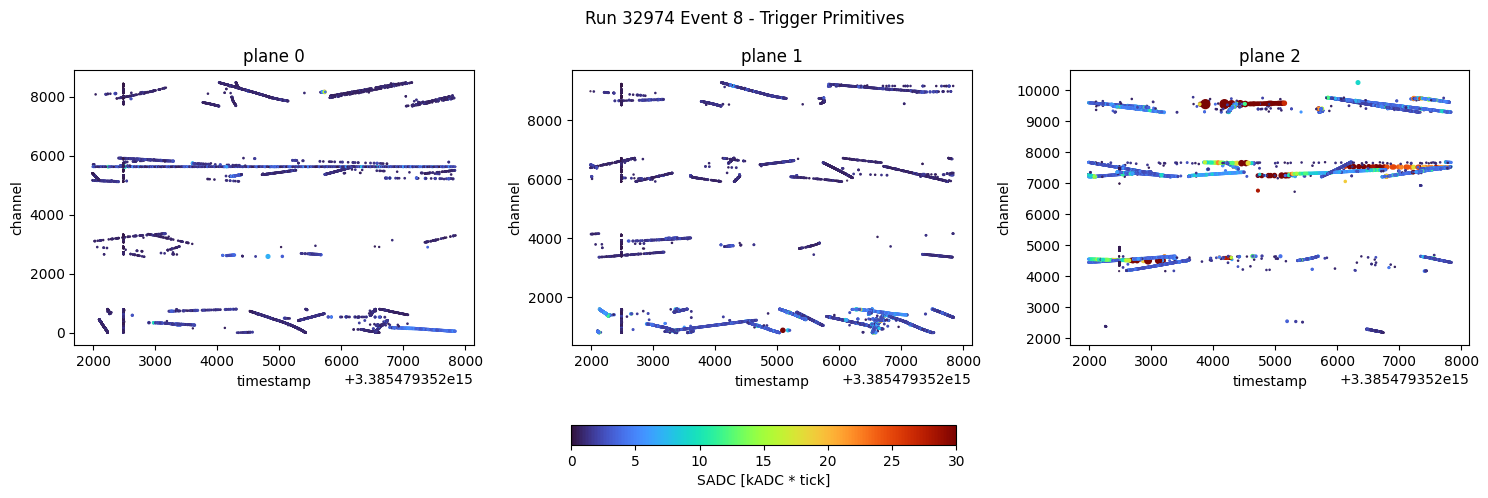

In [14]:
tps_32974 = df_32974[(df_32974.event == event) & (df_32974.TP_peakADC> 120)] #removing some noise from pileup
#vmin, vmax = tps_32974["TP_SADC"].min()/1e3, (tps_32974["TP_SADC"].max()/1e3)/2
print(f"Minimum value {tps_32974['TP_SADC'].min()/1e3}, maximum {(tps_32974['TP_SADC'].max()/1e3)/2}, mean {tps_32974['TP_SADC'].mean()/1e3}, std deviation {tps_32974['TP_SADC'].std()/1e3}")
vmin, vmax = (0, 30) #Low energy boundary

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for plane in range(3):
    tps = tps_32974[tps_32974.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")

fig.suptitle(f"Run {df_32974['run'].unique()[0]} Event {event} - Trigger Primitives")
fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

- Induction planes appear to be noisier and have less SADC variations.
- Increased noise due to pile-up of simultaneous activity.
- More variable noise levels compared to MC simulations, and noisy/dead channels (which can change across multiple trigger records, as the data taking conditions are never exactly the same!)

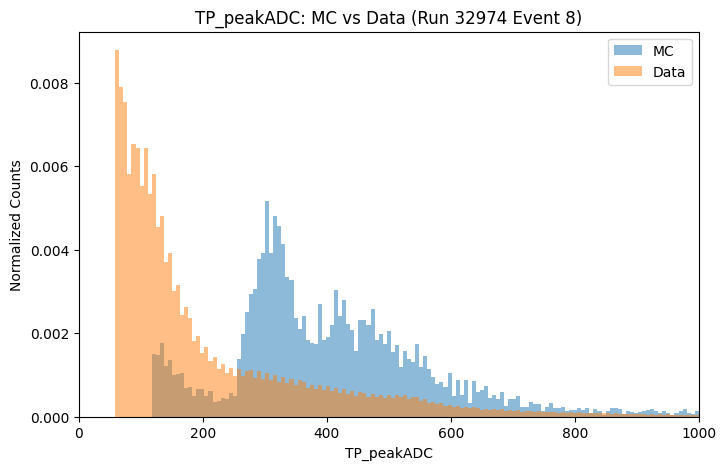

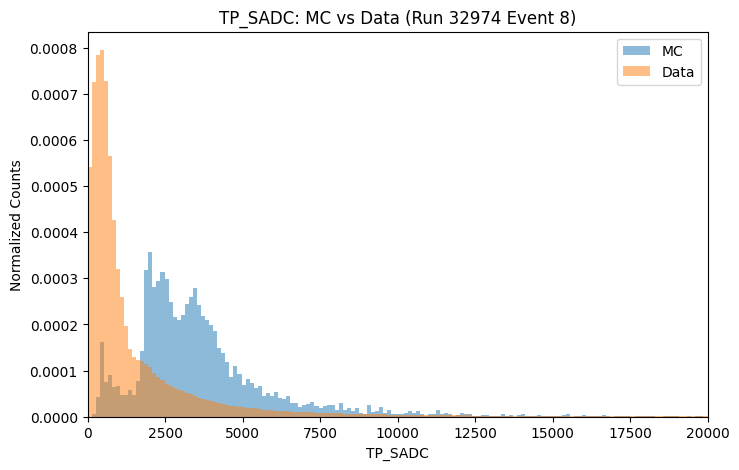

In [22]:
# Compare TP_peakADC distributions
tp_peakadc_bins = np.linspace(0, 1000, int(2*np.sqrt(len(tps))))

plt.figure(figsize=(8,5))
plt.hist(tps['TP_peakADC'], bins=tp_peakadc_bins, alpha=0.5, label='MC', density=True)
plt.hist(df_32974['TP_peakADC'], bins=tp_peakadc_bins, alpha=0.5, label='Data', density=True)
plt.xlabel('TP_peakADC')
plt.ylabel('Normalized Counts')
plt.xlim(0, 1000)
plt.legend()
plt.title(f"TP_peakADC: MC vs Data (Run {df_32974['run'].unique()[0]} Event {event})")
plt.show()

# Compare TP_SADC distributions
tp_sadc_bins = np.linspace(0, 20000,int(2*np.sqrt(len(tps))))

plt.figure(figsize=(8,5))
plt.hist(tps['TP_SADC'], bins=tp_sadc_bins, alpha=0.5, label='MC', density=True)
plt.hist(df_32974['TP_SADC'], bins=tp_sadc_bins, alpha=0.5, label='Data', density=True)
plt.xlabel('TP_SADC')
plt.ylabel('Normalized Counts')
plt.xlim(0, 20000)
plt.legend()
plt.title(f"TP_SADC: MC vs Data (Run {df_32974['run'].unique()[0]} Event {event})")
plt.show()


- Clearly a presence of peak at lower energy and lower thresholds (noisier data) + a bump that corresponds to real cosmic muon data

### General look at the activity per APA 

In [ ]:
def plot_TPC_activity(tp_df, thresh, vmin=None, vmax=None, show_counts=True):
    """
    Plots TP activity per APA, usually for SADC thresholds specified with the thresh but it is optional.
    Pass a DataFrame containing all trigger primitives. Plots the Tp_peakT vs TP_channel for each APA: size proportional to TP_TOT and color proportional to TP_SADC. Title is "TP activity per APA" + run type and threshold cuts.
    Also plots bar chart of TP counts per APA when show_counts is True (default). Title of the histogram is set to "TP Activity per APA, Collection plane" by default but can customized with threshold cuts.
    """
    apa_ranges = {
        "APA1": (0, 2560),
        "APA3": (2560, 5120),
        "APA2": (5120, 7680),
        "APA4": (7680, 10240),
    }
    apa_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    title_prefix="TP Activity per APA, Collection plane\n"

    filtered = tp_df[tp_df.TP_peakADC > thresh]
    print(f"Threshold: {thresh} (TPs: {len(filtered)}, Retaining {len(filtered)/len(tp_df)*100:.2f}% of raw TP)")
    run_type = tp_df.run_name
    plot_title = f"{title_prefix} ({run_type}, threshold: {thresh:.0f} ADC)"

    # --- Scatter plots ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for i, (apa, (start, stop)) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
        sc = ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel,
            s=df_apa.TP_TOT / 10,
            c=df_apa.TP_SADC if thresh is not None else df_apa.TP_SADC / 1e3,
            cmap="turbo",
            alpha=0.7,
            edgecolor="none",
            vmin=vmin, vmax=vmax
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)

    plt.suptitle(f"{plot_title}", fontsize=18)
    if thresh is not None:
        fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
    plt.show()

    # --- Bar plot: TP count per APA ---
    if show_counts:
        apa_counts = [
            len(filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)])
            for (start, stop) in apa_ranges.values()
        ]
        plt.figure(figsize=(8, 5))
        plt.bar(apa_ranges.keys(), apa_counts, color=apa_colors)
        plt.ylabel("Number of TPs")
        plt.title(f"Total TP Count per APA, Collection plane\n({'threshold: ' + str(thresh) if thresh is not None else 'no cut'})")
        plt.show()

Run 32973
Threshold: 100 (TPs: 137116, Retaining 75.44% of raw TP)


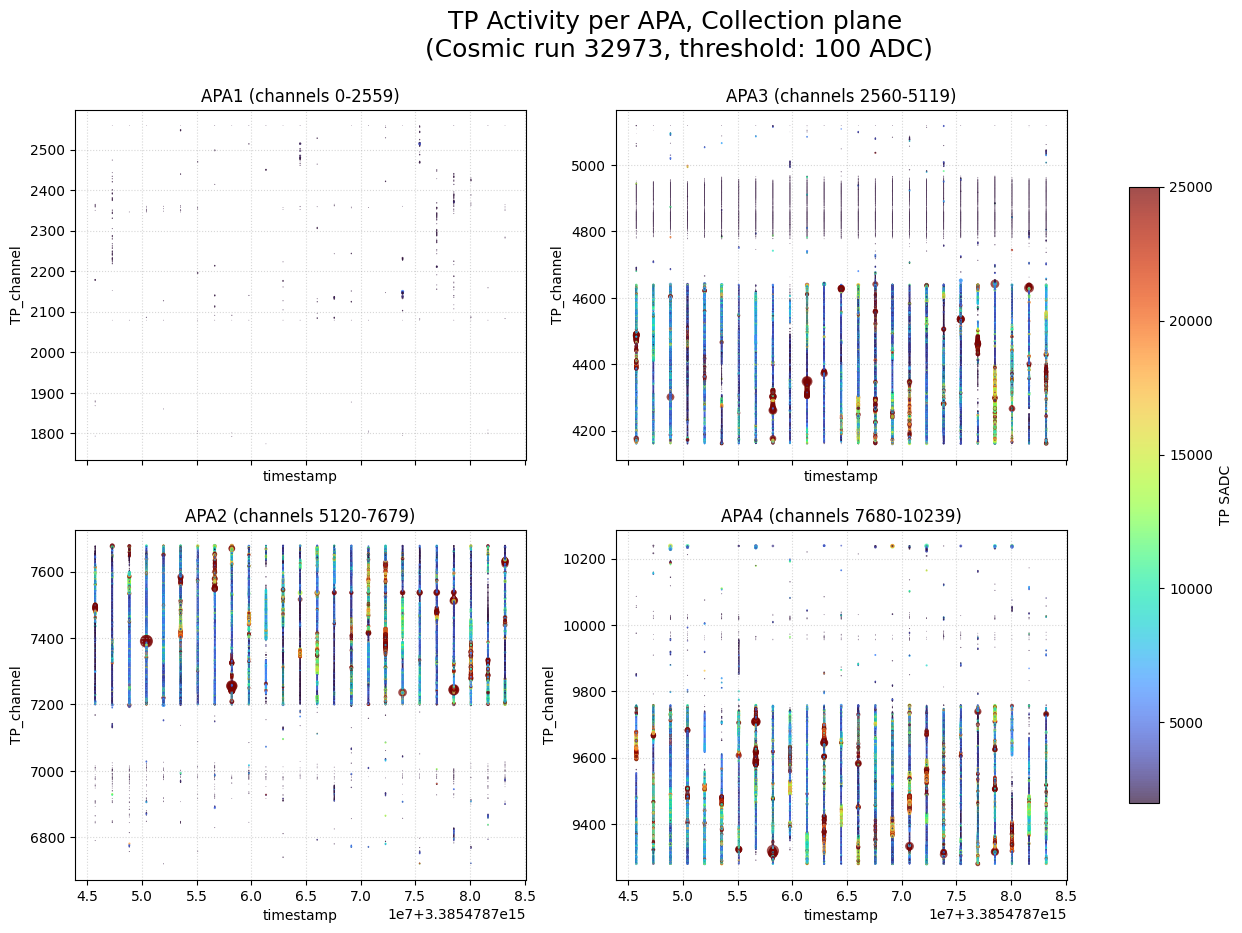

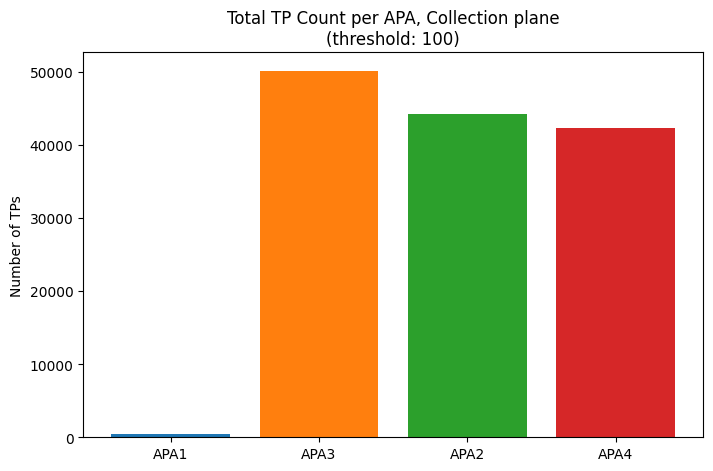

Run 32974
Threshold: 100 (TPs: 237745, Retaining 76.41% of raw TP)


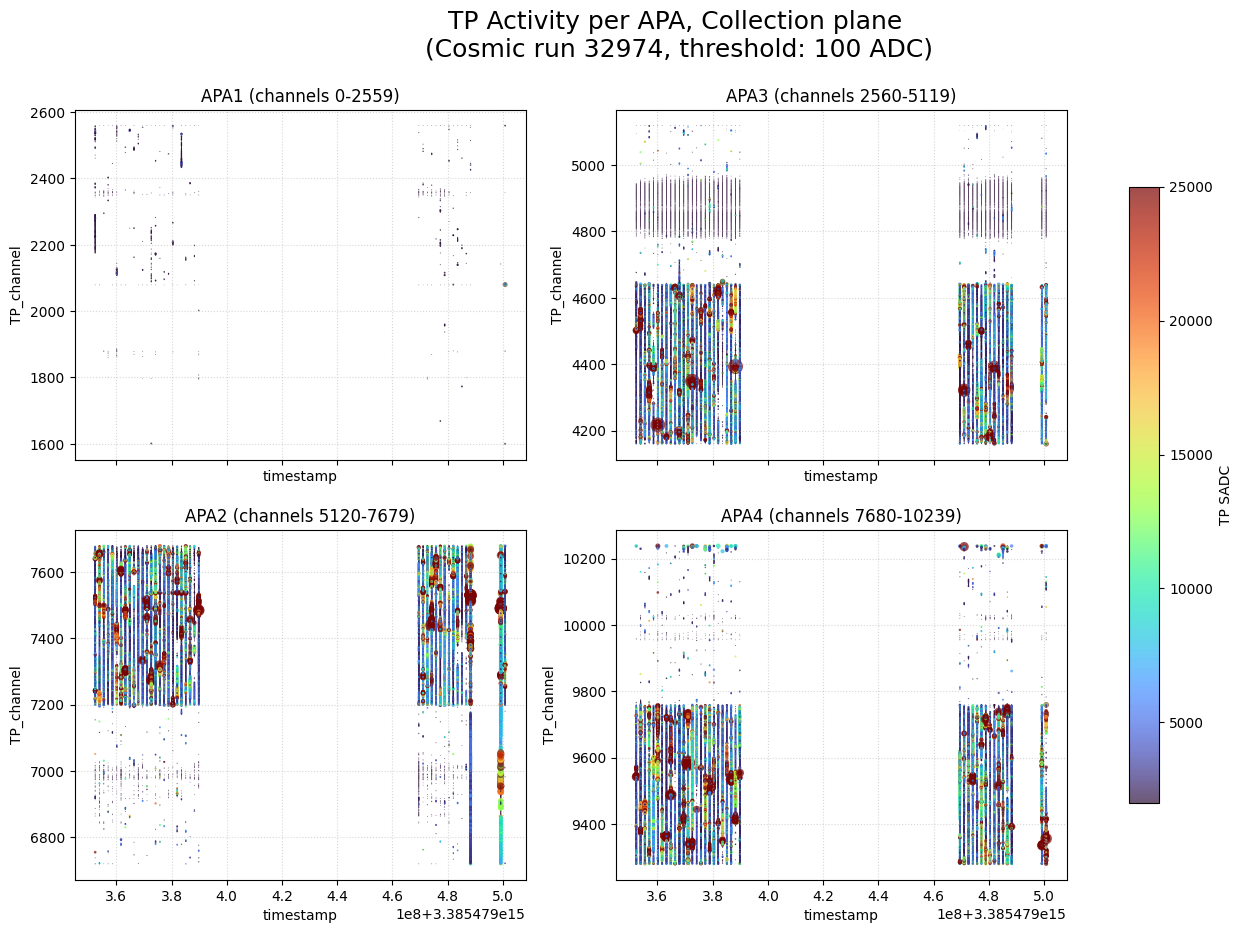

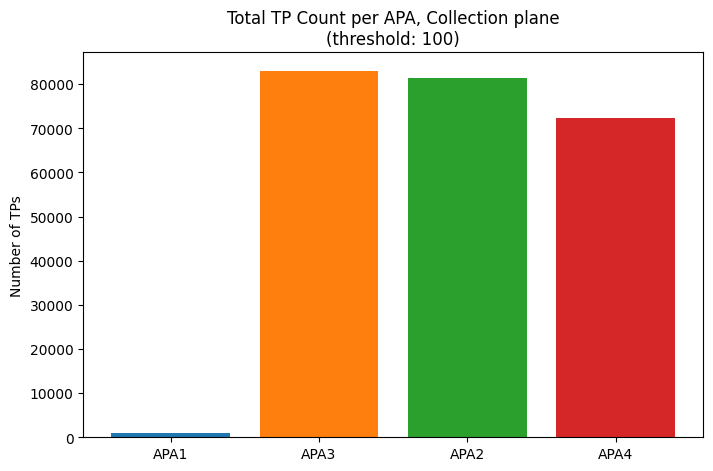

Run 32975
Threshold: 100 (TPs: 184169, Retaining 75.88% of raw TP)


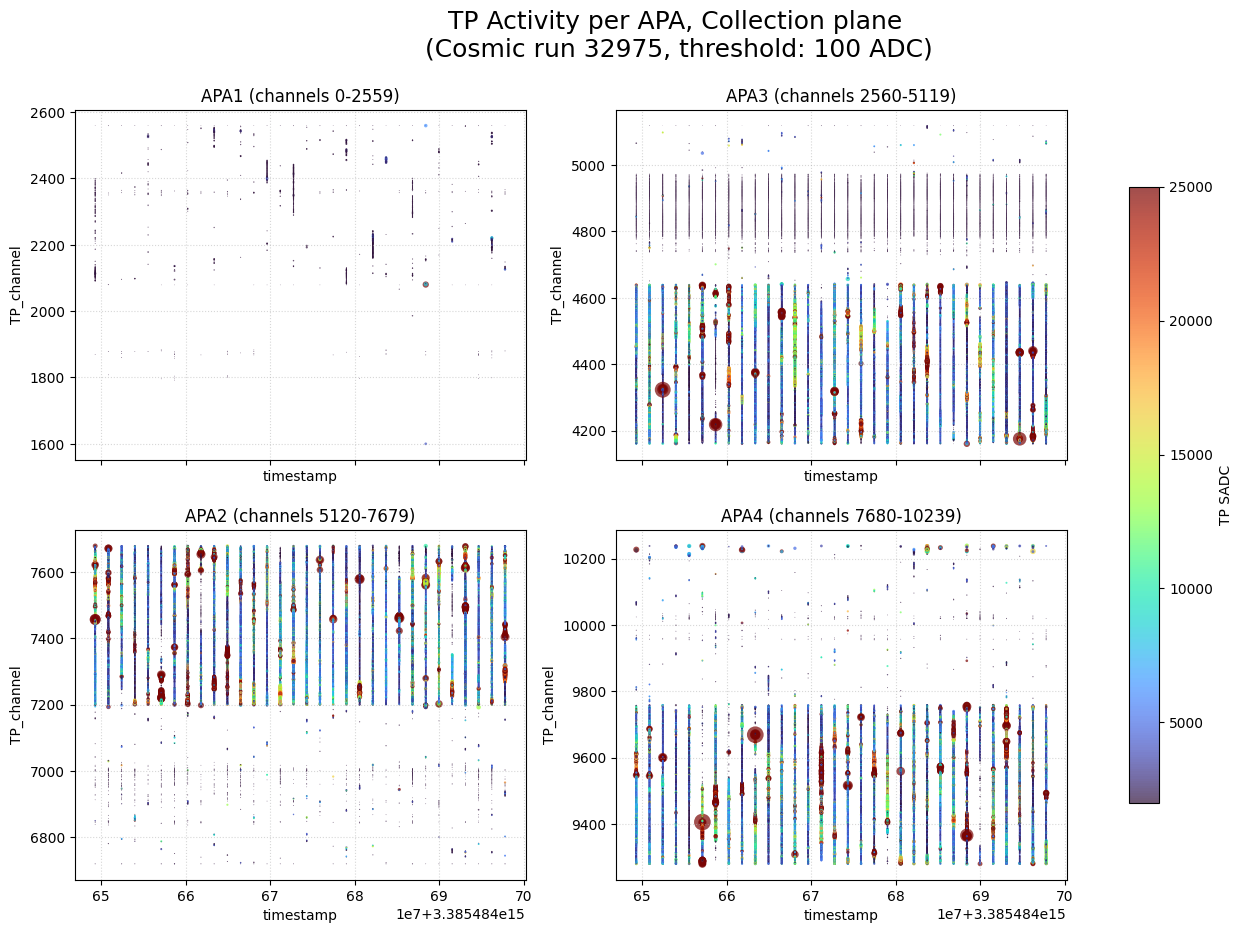

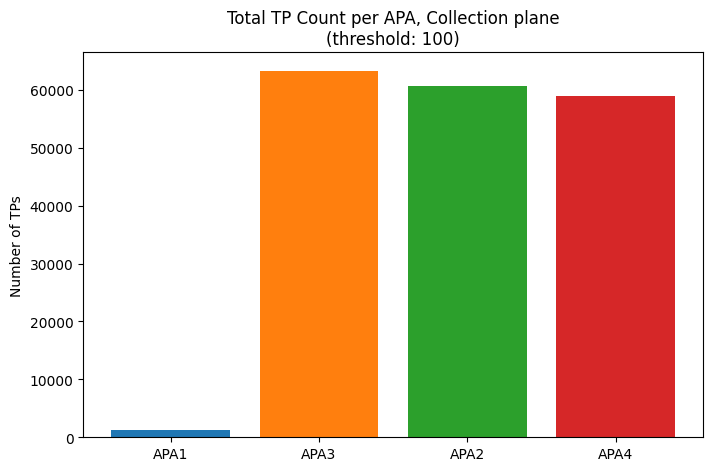

In [29]:
print("Run 32973")
Coll_32973=df_32973[df_32973.TP_plane==2]
Coll_32973.run_name = "Cosmic run 32973"

plot_TPC_activity(Coll_32973, thresh=100, vmin=2000, vmax= 25000)

print("Run 32974")
Coll_32974=df_32974[df_32974.TP_plane==2]
Coll_32974.run_name = "Cosmic run 32974"
plot_TPC_activity(Coll_32974, thresh=100, vmin=2000, vmax=25000)

print("Run 32975")
Coll_32975=df_32975[df_32975.TP_plane==2]
Coll_32975.run_name = "Cosmic run 32975"
plot_TPC_activity(Coll_32975, thresh=100, vmin=2000, vmax=25000)

You can clearly see that it is more difficult to understand the real distribution of data while looking at all the events at the same time. Check Notebook Run_test_event_run_TPC to hae more clarifications on the project.

Also you can clearly see APA1 is broken.

In [ ]:
def quantify_TPC_pileup_APA(tps, time_window_us=10000):
    """
    Quantifies pileup (TPs per time window) separately for each APA.
    Returns a dict {APA_name: (counts_per_window, pileup_stats)}
    """
    global apa_ranges
    apa_pileup = {}
    for apa, (start, stop) in apa_ranges.items():
        df_apa = tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]
        if df_apa.empty:
            apa_pileup[apa] = (np.array([]), {
                'mean_TPs_per_window': 0,
                'std_TPs_per_window': 0,
                'pileups': 0,
                'total_windows': 0,
                'pile up percentage': 0
            })
            continue
        tmin, tmax = df_apa.TP_peakT.min(), df_apa.TP_peakT.max()
        # Ensure at least one bin, otherwise np.histogram will error on empty bins
        if tmin == tmax:
            bins = np.array([tmin, tmin + time_window_us])
        else:
            bins = np.arange(tmin, tmax + time_window_us, time_window_us)
        counts, _ = np.histogram(df_apa.TP_peakT, bins=bins)
        mean_counts = float(np.mean(counts)) if len(counts) > 0 else 0
        std_counts = float(np.std(counts)) if len(counts) > 0 else 0
        pileup_threshold = mean_counts + 3 * std_counts
        pileups = int((counts > pileup_threshold).sum())
        pileup_percentage = (pileups / len(counts) * 100) if len(counts) > 0 else 0
        pileup_stats = {
            'mean_TPs_per_window': mean_counts,
            'std_TPs_per_window': std_counts,
            'pileups': pileups,
            'total_windows': len(counts),
            'pile up percentage': pileup_percentage
        }
        apa_pileup[apa] = (counts, pileup_stats)
    return apa_pileup

def quantify_visible_energy_APA(tps, time_window_us=1000, adc_tick_to_mev=0.039):
    """
    Computes the visible energy (sum of TP_SADC × conversion) per time window for each APA.
    adc_tick_to_mev=0.039 from literature: https://arxiv.org/abs/2505.18073
    Returns a dict {APA_name: (energy_per_window, energy_stats)}
    """
    global apa_ranges

    apa_energy = {}
    for apa, (start, stop) in apa_ranges.items():
        df_apa = tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]
        if df_apa.empty:
            apa_energy[apa] = (np.array([]), {'mean_E_per_window_MeV': 0, 'max_E_per_window_MeV': 0})
            continue
        tmin, tmax = df_apa.TP_peakT.min(), df_apa.TP_peakT.max()
        bins = np.arange(tmin, tmax + time_window_us, time_window_us)
        df_apa = df_apa.copy()
        df_apa["time_bin"] = np.digitize(df_apa.TP_peakT, bins) - 1
        energy_per_bin = df_apa.groupby('time_bin')['TP_SADC'].sum().reindex(range(len(bins)-1), fill_value=0)
        energy_per_bin_MeV = energy_per_bin.values * adc_tick_to_mev
        energy_stats = {
            'mean_E_per_window_MeV': np.mean(energy_per_bin_MeV),
            'max_E_per_window_MeV': np.max(energy_per_bin_MeV)
        }
        apa_energy[apa] = (energy_per_bin_MeV, energy_stats)
    return apa_energy

In [54]:
def batch_TPC_analysis(run_data_list, vmin_list, vmax_list, adc_tick_to_mev=0.039):
    """
    Performs TP_channels vs TP_peakT plots for a list of runs.
    Performs pileups (by time window) and visible energy for APA.
    """
    for i, (df, vmin, vmax) in enumerate(zip(run_data_list, vmin_list, vmax_list)):
        run_name = getattr(df, "run_name", f"Run {i}")
        print(f"\n--- {run_name} ---")
        # Trova la soglia ottimale TP_peakADC
        df_thr = df[df.TP_peakADC > 180].copy()
        df_thr.run_name = run_name

        # Plot TPC activity (scatter + bar plot of activity per APA)
        plot_TPC_activity(df_thr, 180, vmin=vmin, vmax=vmax, show_counts=True)

        # Pileup per APA (easy method)
        print("\nPileup per APA (TPs per time window):")
        pileup_results = quantify_TPC_pileup_APA(df_thr)
        for apa, (counts, stats) in pileup_results.items():
            print(f"  {apa}: mean={stats['mean_TPs_per_window']:.2f}, pileup%={stats['pile up percentage']:.2f}%")



--- Cosmic run 32973 ---
Threshold: 180 (TPs: 117520, Retaining 100.00% of raw TP)


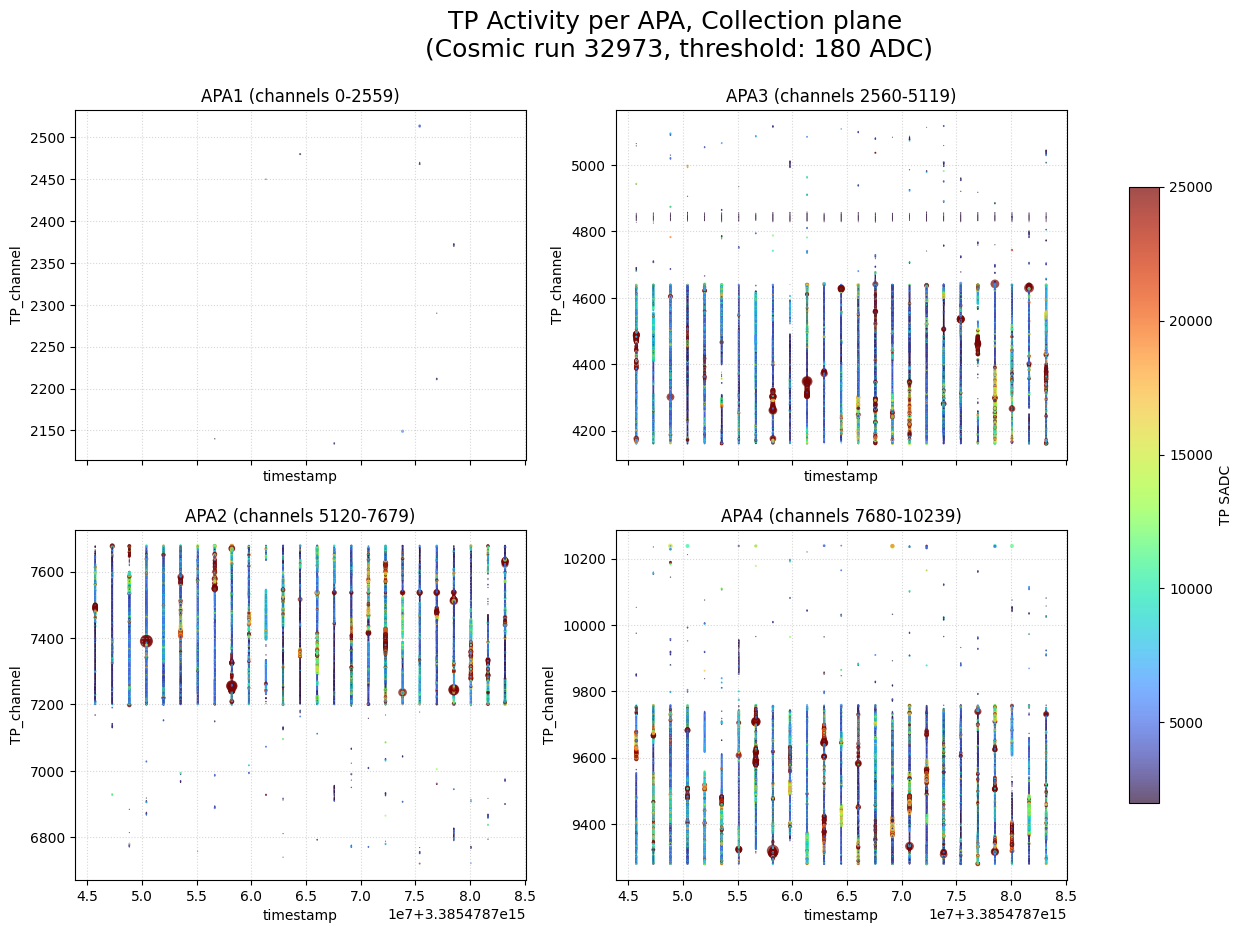

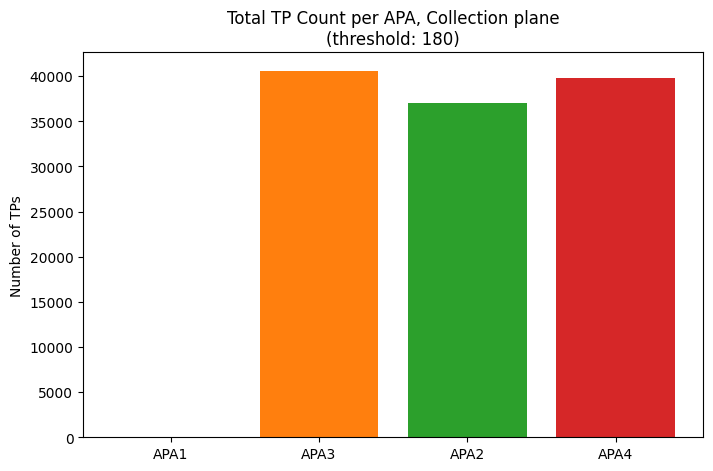


Pileup per APA (TPs per time window):
  APA1: mean=0.01, pileup%=0.41%
  APA3: mean=10.83, pileup%=0.91%
  APA2: mean=9.88, pileup%=0.77%
  APA4: mean=10.62, pileup%=0.83%

--- Cosmic run 32974 ---
Threshold: 180 (TPs: 203994, Retaining 100.00% of raw TP)


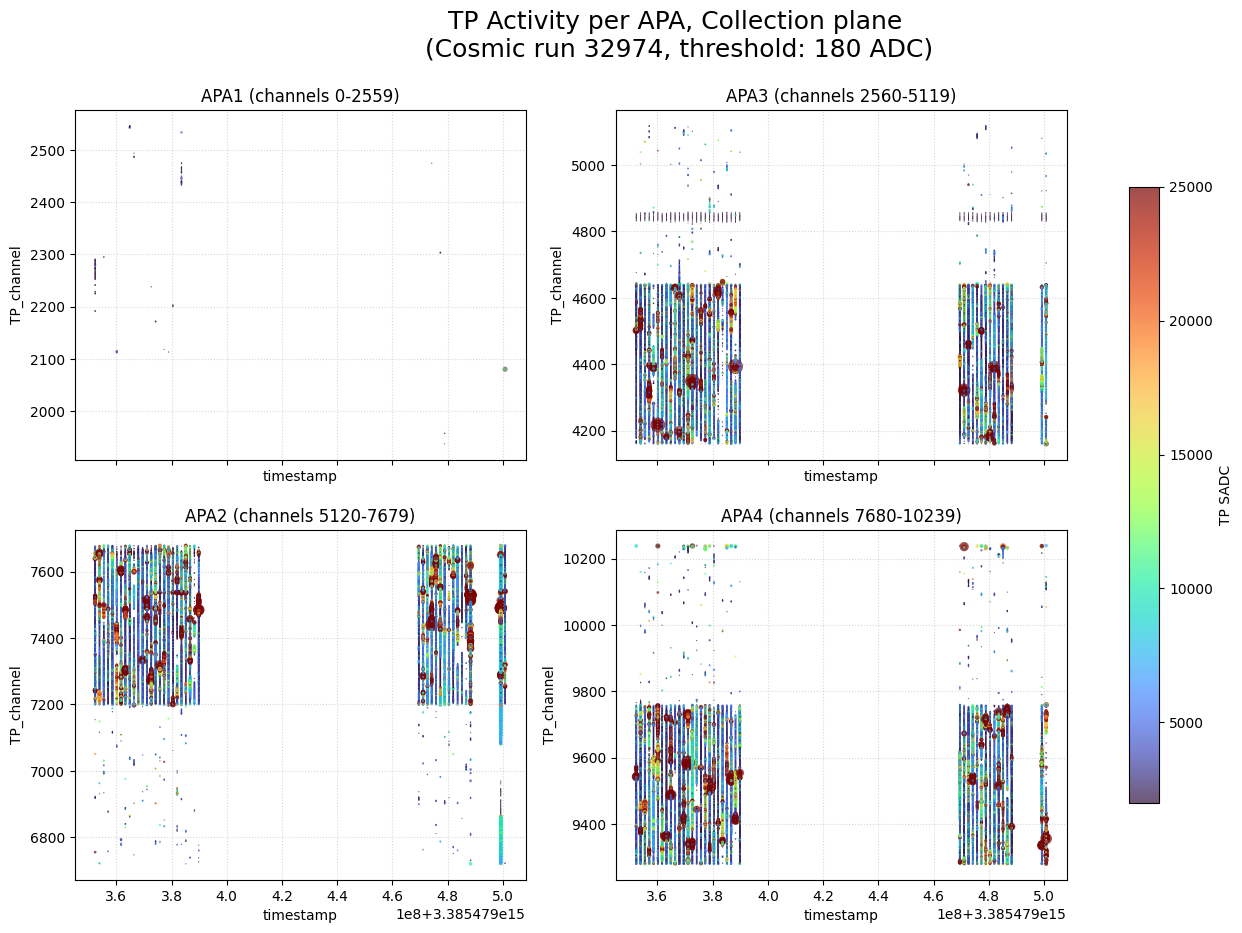

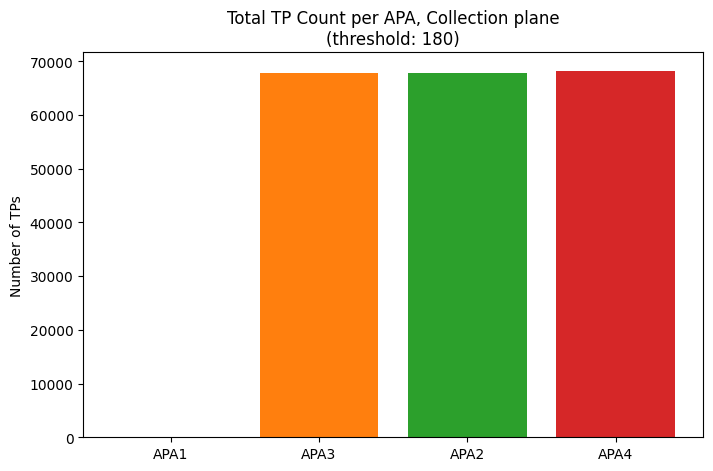


Pileup per APA (TPs per time window):
  APA1: mean=0.01, pileup%=0.07%
  APA3: mean=4.56, pileup%=0.36%
  APA2: mean=4.57, pileup%=0.34%
  APA4: mean=4.60, pileup%=0.35%

--- Cosmic run 32975 ---
Threshold: 180 (TPs: 160848, Retaining 100.00% of raw TP)


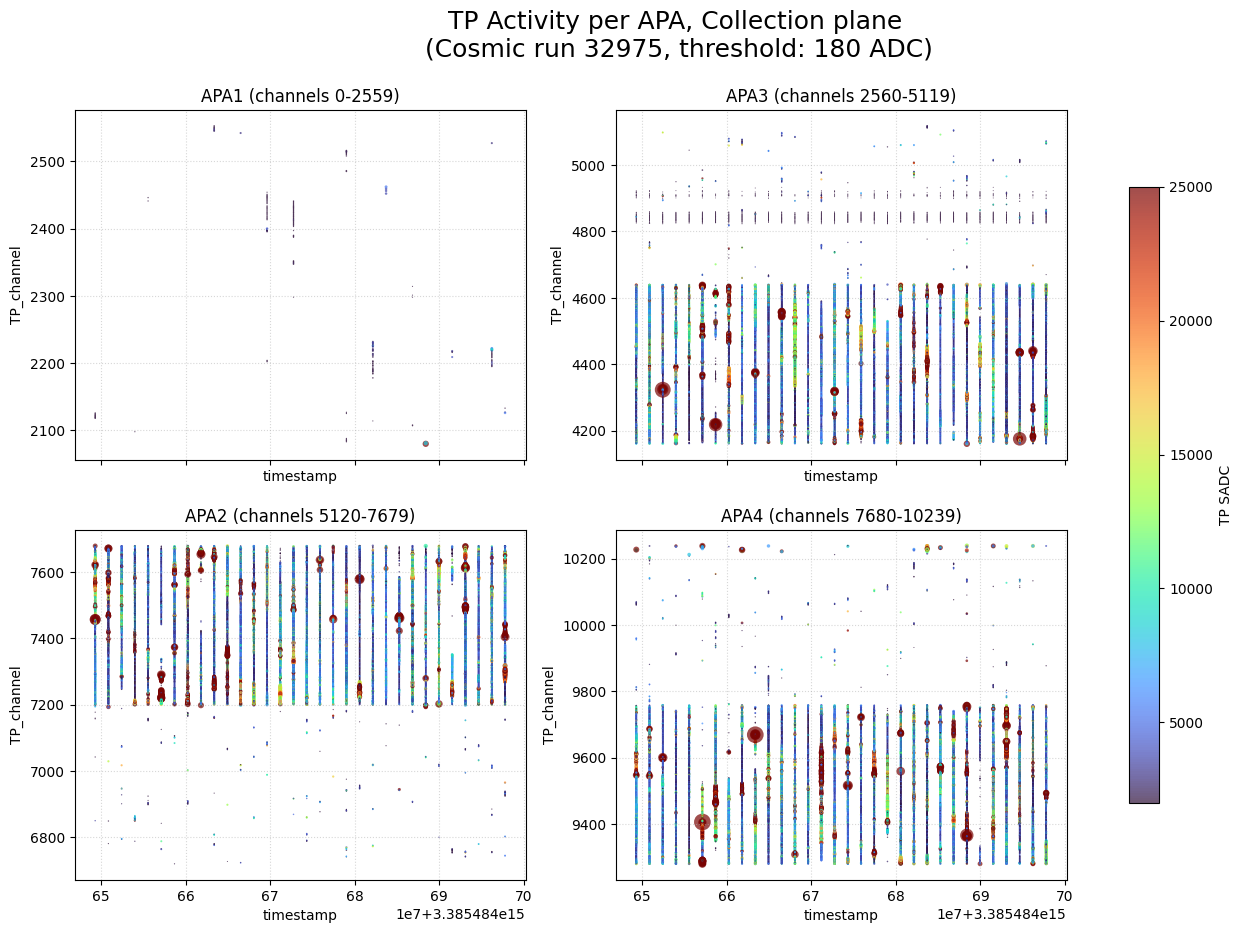

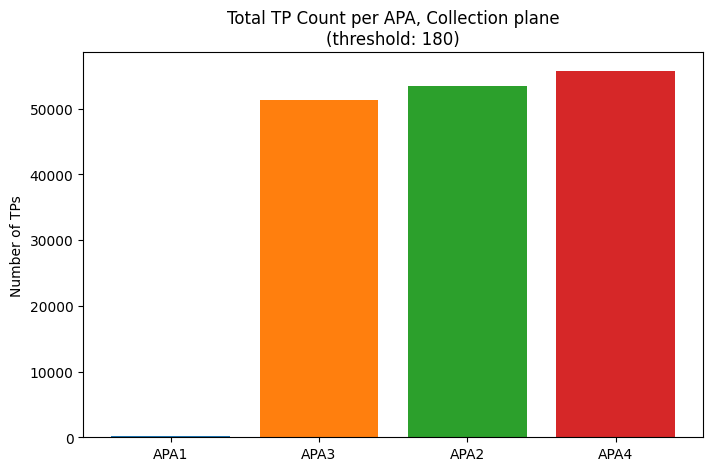


Pileup per APA (TPs per time window):
  APA1: mean=0.05, pileup%=0.21%
  APA3: mean=10.60, pileup%=0.76%
  APA2: mean=11.04, pileup%=0.76%
  APA4: mean=11.51, pileup%=0.70%


In [55]:
run_data_list = [Coll_32973, Coll_32974, Coll_32975]
vmin_list = [2000, 2000, 2000]
vmax_list = [25000, 25000, 25000]

batch_TPC_analysis(run_data_list, vmin_list, vmax_list)